<table>
    <tr>
        <td  style="background-color:#ffffff;"><a href="https://qsoftware.lu.lv/index.php/qworld/" target="_blank"><img src="..\images\qworld.jpg" width="70%" align="left"></a></td>
        <td style="background-color:#ffffff;" width="*"></td>
        <td  style="background-color:#ffffff;vertical-align:text-top;"><a href="https://qsoftware.lu.lv" target="_blank"><img src="..\images\logo.jpg" width="25%" align="right"></a></td>        
    </tr>
    <tr><td colspan="3" align="right" style="color:#777777;background-color:#ffffff;font-size:12px;">
        prepared by Maksim Dimitrijev<br>
        contributed by Özlem Salehi (improvements for Oracle implementation with Phase kickback).
    </td></tr>
    <tr><td colspan="3" align="right" style="color:#bbbbbb;background-color:#ffffff;font-size:11px;font-style:italic;">
        This cell contains some macros. If there is a problem with displaying mathematical formulas, please run this cell to load these macros.
    </td></tr>
</table>
$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\dot}[2]{ #1 \cdot #2} $
$ \newcommand{\biginner}[2]{\left\langle #1,#2\right\rangle} $
$ \newcommand{\mymatrix}[2]{\left( \begin{array}{#1} #2\end{array} \right)} $
$ \newcommand{\myvector}[1]{\mymatrix{c}{#1}} $
$ \newcommand{\myrvector}[1]{\mymatrix{r}{#1}} $
$ \newcommand{\mypar}[1]{\left( #1 \right)} $
$ \newcommand{\mybigpar}[1]{ \Big( #1 \Big)} $
$ \newcommand{\sqrttwo}{\frac{1}{\sqrt{2}}} $
$ \newcommand{\dsqrttwo}{\dfrac{1}{\sqrt{2}}} $
$ \newcommand{\onehalf}{\frac{1}{2}} $
$ \newcommand{\donehalf}{\dfrac{1}{2}} $
$ \newcommand{\hadamard}{ \mymatrix{rr}{ \sqrttwo & \sqrttwo \\ \sqrttwo & -\sqrttwo }} $
$ \newcommand{\vzero}{\myvector{1\\0}} $
$ \newcommand{\vone}{\myvector{0\\1}} $
$ \newcommand{\vhadamardzero}{\myvector{ \sqrttwo \\  \sqrttwo } } $
$ \newcommand{\vhadamardone}{ \myrvector{ \sqrttwo \\ -\sqrttwo } } $
$ \newcommand{\myarray}[2]{ \begin{array}{#1}#2\end{array}} $
$ \newcommand{\X}{ \mymatrix{cc}{0 & 1 \\ 1 & 0}  } $
$ \newcommand{\Z}{ \mymatrix{rr}{1 & 0 \\ 0 & -1}  } $
$ \newcommand{\Htwo}{ \mymatrix{rrrr}{ \frac{1}{2} & \frac{1}{2} & \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & -\frac{1}{2} & \frac{1}{2} & -\frac{1}{2} \\ \frac{1}{2} & \frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} \\ \frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} & \frac{1}{2} } } $
$ \newcommand{\CNOT}{ \mymatrix{cccc}{1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0} } $
$ \newcommand{\norm}[1]{ \left\lVert #1 \right\rVert } $

<h2>Grover's Search: Implementation</h2>

Now we will consider how to implement Grover's search with available gates. Let's recall the whole algorithm with the basic case.

We are given $N=2^n$ elements, and one element is marked. The task is to find this marked element.

We are given $n$ qubits. At the beginning we apply Hadamard to each qubit, so we put our quantum state into superposition. The amplitude of each basis state $ \ket{0 \cdots 0}, \ldots, \ket{1 \cdots 1} $ is set to $ \frac{1}{\sqrt{N}} $. After that we iterate the following algorithm for several times:
<ul>
    <li>Make a query: apply a query oracle operator to qubits - it flips the sign of the state that corresponds to the marked element.</li>
    <li>Inversion: apply a diffusion matrix - the value of each element is reflected over the mean of all values.</li>
</ul>

Let's check how can we implement the query and inversion operations.

<h3>Query operation</h3>

Suppose that there exists a function $f$ with the following properties:

\begin{align*}
f(x)&=1 &\mbox{ if $x$ is marked}\\
f(x)&=0 &\mbox{ otherwise}
\end{align*}

The Grover's algorithm does not actually search a list of elements, but given that there exists a function $f$ with the given properties, it finds the marked element $x$ such that $f(x)=1$. An operator which flips the sign of the amplitude of the state corresponding to $x$ can be constructed using a procedure called <font color="blue">phase-kickback</font>.

Query operator is an identity operator with entry $-1$ corresponding to the marked element. Suppose that we have $N=4$ elements and the last one is marked. In such case our query operator will look like this:

$\mymatrix{cccc}{1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1}$.

To implement such operator with phase kickback we need ancilla (additional) qubit in state $\frac{1}{\sqrt{2}} (\ket{0} - \ket{1})$. This state is achievable by applying x-gate and h-gate to the qubit in state $\ket{0}$. After that, we can affect the needed state with phase-kickback to flip the sign. For this purpose we just need to perform controlled NOT operation, where our qubits act as controllers, and ancilla is the targed qubit. Let's check the implementation.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

qreg1 =  QuantumRegister(3)
creg1 = ClassicalRegister(3)

circuit1 = QuantumCircuit(qreg1,creg1)

# prepare ancilla qubit
circuit1.x(qreg1[2])
circuit1.h(qreg1[2])

circuit1.ccx(qreg1[0],qreg1[1],qreg1[2])

# put ancilla qubit back into state |0>
circuit1.h(qreg1[2])
circuit1.x(qreg1[2])

job = execute(circuit1,Aer.get_backend('unitary_simulator'))
u=job.result().get_unitary(circuit1,decimals=3)
for i in range(len(u)):
    s=""
    for j in range(len(u)):
        val = str(u[i][j].real)
        while(len(val)<5): val  = " "+val
        s = s + val
    print(s)

circuit1.draw(output='mpl')

  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
  0.0  0.0  0.0 -1.0  0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0


<Figure size 680.594x367.889 with 1 Axes>

Now we discuss the details of the implementation. ccx-gate affects the target qubit if both controller qubits are in state $\ket{1}$. Because the target qubit is in state $\frac{1}{\sqrt{2}} (\ket{0} - \ket{1})$, we observe phase-kickback effect, which flips the sign of the state that controls the ancilla qubit. Therefore, the sign of the state 11 is flipped. The top-left $4 \times 4$ matrix corresponds to query operator with element 11 being marked.

How can we flip the sign of other states? Remember our efforts to affect controlled rotation with other states (Multiple rotations). We can use the same trick here. If we flip the state of the qubit, then it will control the operation if it was initially in state $\ket{0}$. Let's check another example, now our marked element is 01.

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

qreg2 =  QuantumRegister(3)
creg2 = ClassicalRegister(3)

circuit2 = QuantumCircuit(qreg2,creg2)

# prepare ancilla qubit
circuit2.x(qreg2[2])
circuit2.h(qreg2[2])

circuit2.x(qreg2[1])
circuit2.ccx(qreg2[0],qreg2[1],qreg2[2])
circuit2.x(qreg2[1])

# put ancilla qubit back into state |0>
circuit2.h(qreg2[2])
circuit2.x(qreg2[2])

job = execute(circuit2,Aer.get_backend('unitary_simulator'))
u=job.result().get_unitary(circuit2,decimals=3)
for i in range(len(u)):
    s=""
    for j in range(len(u)):
        val = str(u[i][j].real)
        while(len(val)<5): val  = " "+val
        s = s + val
    print(s)

<h3>Task 1</h3>

Implement the query operation for $n=2$ ($N=4$). Define a function which marks any one of asked elements.

As a result you need to define the following function: <i>query(circuit,quantum_reg,number)</i>, where:
<ul>
    <li><i>circuit</i> allows to pass the quantum circuit;</li>
    <li><i>quantum_reg</i> allows to pass the quantum register;</li>
    <li><i>number</i> is the number of marked element, between 0 and 3, where 0 corresponds to 00 and 3 corresponds to 11 (like binary numbers :) ).</li>
</ul>

In [4]:
def modFunc(state):
    a = []
    a_inverse = []
    for i in range(2):
        a.append(0)
        a_inverse.append(0)
        
    t1 = state
    t2 = state
    for i in range(2):
        t2 = t1 % 2
        t1 = t1 // 2
        a[i] = t2
        
    return a
    

#number - marked element, between 0 and 3.
def query(circuit,quantum_reg,number):
    #code example (you might need to remove it for your solution):
    circuit.x(quantum_reg[2])
    circuit.h(quantum_reg[2])

    res = modFunc(number)
    
    for i in range(2):
        if (res[i] == 0):
            circuit.x(quantum_reg[i + 1])
    circuit.ccx(quantum_reg[0],quantum_reg[1],quantum_reg[2])
    for i in range(2):
        if (res[i] == 1):
            circuit.x(quantum_reg[i + 1])

    # put ancilla qubit back into state |0>
    circuit.h(quantum_reg[2])
    circuit.x(quantum_reg[2])



You can play around with the following code to see that your function is implementing the query operation. How to use this to mark 2 elements?

In [6]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

qreg3 =  QuantumRegister(3)
creg3 = ClassicalRegister(3)

mycircuit3 = QuantumCircuit(qreg3,creg3)

#Any value between 0 and 3.
query(mycircuit3,qreg3,1)

job = execute(mycircuit3,Aer.get_backend('unitary_simulator'))
u=job.result().get_unitary(mycircuit3,decimals=3)
for i in range(len(u)):
    s=""
    for j in range(len(u)):
        val = str(u[i][j].real)
        while(len(val)<5): val  = " "+val
        s = s + val
    print(s)

  0.0  0.0 -1.0  0.0  0.0  0.0  0.0  0.0
  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0 -1.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0


<a href="B92_Grover_Search_Implementation_Solutions.ipynb#task1">click for our solution</a>

<h3>Task 2 (Optional, challenging)</h3>

Implement the query operation for $n=3$ ($N=8$).

To implements this operation you will need 5 qubits (1 additional qubit to implement controlled operations + ancilla). Use the qubit 3 as additional qubit and qubit 4 as ancilla.

In [ ]:
#number - marked element, between 0 and 7.
def big_query(circuit,quantum_reg,number):
    #code example (you might need to remove it for your solution):
    circuit.x(quantum_reg[0])
    circuit.x(quantum_reg[0])
#
# your code is here
#


You can play around with the following code to see that your function is implementing the query operation.

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

big_qreg =  QuantumRegister(5)
big_creg = ClassicalRegister(5)

big_mycircuit = QuantumCircuit(big_qreg,big_creg)

#Any value between 0 and 7.
big_query(big_mycircuit,big_qreg,5)

job = execute(big_mycircuit,Aer.get_backend('unitary_simulator'))
u=job.result().get_unitary(big_mycircuit,decimals=3)
# print top-left 8x8 entries of the matrix.
for i in range(8):
    s=""
    for j in range(8):
        val = str(u[i][j].real)
        while(len(val)<5): val  = " "+val
        s = s + val
    print(s)

<a href="B92_Grover_Search_Implementation_Solutions.ipynb#task2">click for our solution</a>

<h3>Inversion operation</h3>

Small reminder how does the inversion operation look like:

$$ 2 \mymatrix{ccc}{
    \frac{1}{N}  & \cdots & \frac{1}{N} \\ 
    \vdots & \ddots & \vdots \\
    \frac{1}{N}  & \cdots & \frac{1}{N} \\ 
    } 
- I . $$

To implement the inversion (diffusion) operation, we will need additional (ancilla) qubit. The idea of implementation for inversion operation is the following:
<ul>
    <li>Apply X and H to the ancilla qubit.</li>
    <li>Apply H and X to other qubits that will form our inversion operation.</li>
    <li>Apply controlled NOT operator, where all qubits of inversion operation are for controlling, and ancilla qubit is controlled.</li>
    <li>Apply X to the ancilla qubit.</li>
    <li>Apply X and H to other qubits that will form our inversion operation.</li>
    <li>Apply H and X to the ancilla qubit.</li>
</ul>

Although it looks a bit tricky, you can notice that in first two steps we apply similar gates to our operation and ancilla qubits, and after controlled NOT and NOT to ancilla, we reverse these operations.

You can notice that we use the ancilla in the state $\frac{1}{\sqrt{2}} (\ket{0} - \ket{1})$, like we did for query operation. This is not a coincidence, since we again use phase-kickback. This time we want want to flip the sign of all states, except the state $H\ket{00 \cdots 0}$, which intuitively resembles inversion about the mean. To affect with phase-kickback the state $H\ket{00 \cdots 0}$, we prepare qubits with H and X before the controlled NOT. After controlled NOT we apply X to the ancilla qubit, and this operation reverses the effect of phase-kickback in a way, that all the states will be affected except the chosen one. Therefore, we manage to flip the sign of all needed states. The remaining two steps are just to reverse the first two preparation steps.

<h3>Task 3</h3>

Implement the inversion operation for 4 elements.

In the implementation the ancilla qubit will be qubit 2, while qubits for control are 0 and 1. As a result you should obtain the following values in the top-left $4 \times 4$ entries:

$\mymatrix{cccc}{-0.5 & 0.5 & 0.5 & 0.5 \\ 0.5 & -0.5 & 0.5 & 0.5 \\ 0.5 & 0.5 & -0.5 & 0.5 \\ 0.5 & 0.5 & 0.5 & -0.5}$.

In [7]:
def inversion(circuit,quantum_reg):
    #step 1
    circuit.x(quantum_reg[2])
    circuit.h(quantum_reg[2])
    
    #step 2
    circuit.h(quantum_reg[1])
    circuit.h(quantum_reg[0])
    circuit.x(quantum_reg[1])
    circuit.x(quantum_reg[0])

    #step 3
    circuit.ccx(quantum_reg[1],quantum_reg[0],quantum_reg[2])
    
    #step 4
    circuit.x(quantum_reg[2])

    #step 5
    circuit.x(quantum_reg[1])
    circuit.x(quantum_reg[0])
    circuit.h(quantum_reg[1])
    circuit.h(quantum_reg[0])

    #step 6
    circuit.h(quantum_reg[2])
    circuit.x(quantum_reg[2])

Below you can check the matrix of your inversion operator and how does the circuit look like. We are interested in the top-left $4 \times 4$ part of the matrix, the remaining parts are because we used ancilla qubit.

 -0.5  0.5  0.5  0.5  0.0 -0.0 -0.0  0.0
  0.5 -0.5  0.5  0.5 -0.0  0.0  0.0 -0.0
  0.5  0.5 -0.5  0.5 -0.0  0.0  0.0 -0.0
  0.5  0.5  0.5 -0.5  0.0 -0.0 -0.0  0.0
  0.0  0.0  0.0  0.0  1.0  0.0  0.0 -0.0
  0.0  0.0  0.0  0.0  0.0  1.0 -0.0  0.0
  0.0  0.0  0.0  0.0  0.0 -0.0  1.0  0.0
  0.0  0.0  0.0  0.0 -0.0  0.0  0.0  1.0


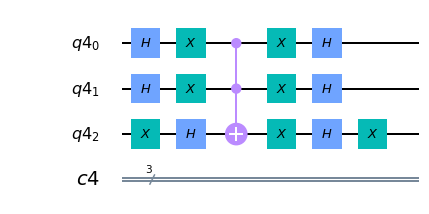

In [8]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

qreg4 =  QuantumRegister(3)
creg4 = ClassicalRegister(3)

mycircuit4 = QuantumCircuit(qreg4,creg4)

inversion(mycircuit4,qreg4)

job = execute(mycircuit4,Aer.get_backend('unitary_simulator'))
u=job.result().get_unitary(mycircuit4,decimals=3)
for i in range(len(u)):
    s=""
    for j in range(len(u)):
        val = str(u[i][j].real)
        while(len(val)<5): val  = " "+val
        s = s + val
    print(s)
    
mycircuit4.draw(output='mpl')

<a href="B92_Grover_Search_Implementation_Solutions.ipynb#task3">click for our solution</a>

<h3>Task 4 (Optional, challenging)</h3>

Implement the inversion operation for $n=3$ ($N=8$). This time you will need 5 qubits - 3 for the operation, 1 for ancilla, and one more qubit to ensure the operation of 3 qubits controlling the other qubit.

In the implementation the ancilla qubit will be qubit 4, while qubits for control are 0, 1 and 2; qubit 3 is used to ensure this multiple control operation. As a result you should obtain the following values in the top-left $8 \times 8$ entries:

$\mymatrix{cccccccc}{-0.75 & 0.25 & 0.25 & 0.25 & 0.25 & 0.25 & 0.25 & 0.25 \\ 0.25 & -0.75 & 0.25 & 0.25 & 0.25 & 0.25 & 0.25 & 0.25 \\ 0.25 & 0.25 & -0.75 & 0.25 & 0.25 & 0.25 & 0.25 & 0.25 \\ 0.25 & 0.25 & 0.25 & -0.75 & 0.25 & 0.25 & 0.25 & 0.25 \\ 0.25 & 0.25 & 0.25 & 0.25 & -0.75 & 0.25 & 0.25 & 0.25 \\ 0.25 & 0.25 & 0.25 & 0.25 & 0.25 & -0.75 & 0.25 & 0.25 \\ 0.25 & 0.25 & 0.25 & 0.25 & 0.25 & 0.25 & -0.75 & 0.25 \\ 0.25 & 0.25 & 0.25 & 0.25 & 0.25 & 0.25 & 0.25 & -0.75}$.

In [ ]:
def big_inversion(circuit,quantum_reg):
    #code example (you might need to remove it for your solution):
    circuit.x(quantum_reg[0])
    circuit.x(quantum_reg[0])
#
# your code is here
#


Below you can check the matrix of your inversion operator. We are interested in the top-left $8 \times 8$ part of the matrix, the remaining parts are because of additional qubits.

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

big_qreg2 =  QuantumRegister(5)
big_creg2 = ClassicalRegister(5)

big_mycircuit2 = QuantumCircuit(big_qreg2,big_creg2)

big_inversion(big_mycircuit2,big_qreg2)

job = execute(big_mycircuit2,Aer.get_backend('unitary_simulator'))
u=job.result().get_unitary(big_mycircuit2,decimals=3)
for i in range(8):
    s=""
    for j in range(8):
        val = str(u[i][j].real)
        while(len(val)<5): val  = " "+val
        s = s + val
    print(s)

<a href="B92_Grover_Search_Implementation_Solutions.ipynb#task4">click for our solution</a>

<h3>Testing Grover's search</h3>

Now we are ready to test our operations and run Grover's search. In the provided code we have 4 elements and among elements 0,1,2,3 the element 1 is marked. We perform just one iteration. You can play around by changing the number of Grover's iterations or marked elements.

We also did a small improvement. Notice that in query and inversion operations we use ancilla qubit in the state $\frac{1}{\sqrt{2}} (\ket{0} - \ket{1})$. We can save some operations by changing ancilla's state only once before and once after Grover's iterations. You can check the circuit to observe the changes.

In [ ]:
%run ../include/quantum.py

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

qreg5 =  QuantumRegister(3)
creg5 = ClassicalRegister(3)

mycircuit5 = QuantumCircuit(qreg5,creg5)

#Grover
#Initial step - superposition.
for i in range(2):
    mycircuit5.h(qreg5[i])
mycircuit5.x(qreg5[2])
mycircuit5.h(qreg5[2])
mycircuit5.barrier()
#Grover's iterations.
for i in range(1):
    oracle1(mycircuit5,qreg5,1)
    mycircuit5.barrier()
    diffusion1(mycircuit5,qreg5)
    mycircuit5.barrier()

mycircuit5.h(qreg5[2])
mycircuit5.x(qreg5[2])
mycircuit5.measure(qreg5,creg5)

job = execute(mycircuit5,Aer.get_backend('qasm_simulator'),shots=10000)
counts5 = job.result().get_counts(mycircuit5)
print(counts5) # print the outcomes

mycircuit5.draw(output='mpl')

<h3>8 element case (optional)</h3>

We will use 2 additional qubits (1 ancilla + 1 qubit for controlled operations). We have $n=3$, $N=8$, and use 5 total qubits. This means that the parts of operation matrices that we are interested in are the top-left $8 \times 8$ entries.

Query operator:

In [ ]:
%run ../include/quantum.py

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

qreg6 =  QuantumRegister(5)
creg6 = ClassicalRegister(5)

mycircuit6 = QuantumCircuit(qreg6,creg6)

#Any value between 0 and 7.
oracle2(mycircuit6,qreg6,1)

job = execute(mycircuit6,Aer.get_backend('unitary_simulator'))
u=job.result().get_unitary(mycircuit6,decimals=3)
# print top-left 8x8 entries of the matrix.
for i in range(8):
    s=""
    for j in range(8):
        val = str(u[i][j].real)
        while(len(val)<5): val  = " "+val
        s = s + val
    print(s)

Inversion operator:

In [ ]:
%run ../include/quantum.py

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

qreg7 =  QuantumRegister(5)
creg7 = ClassicalRegister(5)

mycircuit7 = QuantumCircuit(qreg7,creg7)

diffusion2(mycircuit7,qreg7)

job = execute(mycircuit7,Aer.get_backend('unitary_simulator'))
u=job.result().get_unitary(mycircuit7,decimals=3)
# print top-left 8x8 entries of the matrix.
for i in range(8):
    s=""
    for j in range(8):
        val = str(u[i][j].real)
        while(len(val)<6): val  = " "+val
        s = s + val
    print(s)

You can play around with Grover's search on 8 elements now:

In [ ]:
%run ../include/quantum.py

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

qreg8 =  QuantumRegister(5)
creg8 = ClassicalRegister(5)

mycircuit8 = QuantumCircuit(qreg8,creg8)

#Grover
for i in range(3):
    mycircuit8.h(qreg8[i])
mycircuit8.barrier()
#Try 1,2,6,12 iterations of Grover
for i in range(1):
    oracle2(mycircuit8,qreg8,5)
    mycircuit8.barrier()
    diffusion2(mycircuit8,qreg8)
    mycircuit8.barrier()

mycircuit8.measure(qreg8,creg8)

job = execute(mycircuit8,Aer.get_backend('qasm_simulator'),shots=10000)
counts8 = job.result().get_counts(mycircuit8)
print(counts8) # print the outcomes

<h3>16 element case (optional)</h3>

We will use 3 additional qubits (1 ancilla + 2 qubits for controlled operations). We have $n=4$, $N=16$, and use 7 total qubits. This means that the parts of operation matrices that we are interested in are the top-left $16 \times 16$ entries.

Query operator:

In [ ]:
%run ../include/quantum.py

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

qreg9 =  QuantumRegister(7)
creg9 = ClassicalRegister(7)

mycircuit9 = QuantumCircuit(qreg9,creg9)

#Any value between 0 and 15.
oracle3(mycircuit9,qreg9,0)

job = execute(mycircuit9,Aer.get_backend('unitary_simulator'))
u=job.result().get_unitary(mycircuit9,decimals=3)
# print top-left 16x16 entries of the matrix.
for i in range(16):
    s=""
    for j in range(16):
        val = str(u[i][j].real)
        while(len(val)<5): val  = " "+val
        s = s + val
    print(s)

Inversion operator:

In [ ]:
%run ../include/quantum.py
    
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

qreg10 =  QuantumRegister(7)
creg10 = ClassicalRegister(7)

mycircuit10 = QuantumCircuit(qreg10,creg10)

diffusion3(mycircuit10,qreg10)

job = execute(mycircuit10,Aer.get_backend('unitary_simulator'))
u=job.result().get_unitary(mycircuit10,decimals=3)
# print top-left 16x16 entries of the matrix.
for i in range(16):
    s=""
    for j in range(16):
        val = str(u[i][j].real)
        while(len(val)<7): val  = " "+val
        s = s + val
    print(s)

You can play around with Grover's search on 16 elements now:

In [ ]:
%run ../include/quantum.py

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

qreg11 =  QuantumRegister(7)
creg11 = ClassicalRegister(7)

mycircuit11 = QuantumCircuit(qreg11,creg11)

#Grover
for i in range(4):
    mycircuit11.h(qreg11[i])
mycircuit11.barrier()

for i in range(1):
    oracle3(mycircuit11,qreg11,0)
    mycircuit11.barrier()
    diffusion3(mycircuit11,qreg11)
    mycircuit11.barrier()

mycircuit11.measure(qreg11,creg11)

job = execute(mycircuit11,Aer.get_backend('qasm_simulator'),shots=10000)
counts11 = job.result().get_counts(mycircuit11)
print(counts11) # print the outcomes

<h3>Task 5 (optional)</h3>

Do you remember which number of iterations is optimal to find the marked element with Grover's search? Good. Here we have a quantum program with one marked element. First, determine the total number of elements in this program. After that please pick the optimal number of iterations. You can check your guess by changing the value of <i>iteration_count</i>, please also check less optimal options like <i>iteration_count-1</i>, <i>iteration_count+1</i>.

In [ ]:
%run ../include/quantum.py

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

qreg12 =  QuantumRegister(19)
creg12 = ClassicalRegister(19)

mycircuit12 = QuantumCircuit(qreg12,creg12)

for i in range(10):
    mycircuit12.h(qreg12[i])

mycircuit12.x(qreg12[18])
mycircuit12.h(qreg12[18])

#number of iterations - change this value
iteration_count = 0
for i in range(iteration_count):
    giant_oracle(mycircuit12,qreg12,0)
    giant_diffusion(mycircuit12,qreg12)
    
mycircuit12.h(qreg12[18])
mycircuit12.x(qreg12[18])

mycircuit12.measure(qreg12,creg12)

job = execute(mycircuit12,Aer.get_backend('qasm_simulator'),shots=10000)
counts12 = job.result().get_counts(mycircuit12)
print(counts12)